# MGC-X and DCorr-X: Independence Testing for Time Series

In this tutorial, we explore

- The theory behind the Cross Distance Correlation (DCorr-X) and Cross Multiscale Graph Correlation (MGC-X) tests
- The unique methodological features such as optimal scale and optimal lag
- A "fast" extension
- The features of the implementation

## Theory

### Notation
Let $\mathbb{N}$ be the non-negative integers $\{0, 1, 2, ...\}$, and $\mathbb{R}$ be the real line $(-\infty, \infty)$. Let $F_X$, $F_Y$, and $F_{X,Y}$ represent the marginal and joint distributions of random variables $X$ and $Y$, whose realizations exist in $\mathcal{X}$ and $\mathcal{Y}$, respectively. Similarly, Let $F_{X_t}$, $F_{Y_s}$, and $F_{(X_t,Y_s)}$ represent the marginal and joint distributions of the time-indexed random variables $X_t$ and $Y_s$ at timesteps $t$ and $s$. For this work, assume $\mathcal{X} = \mathbb{R}^p$ and $\mathcal{Y} = \mathbb{R}^q$ for $p, q > 0$. Finally, let $\{(X_t,Y_t)\}_{t=-\infty}^{\infty}$ represent the full, jointly-sampled time series, structured as a countably long list of observations $(X_t, Y_t)$. 

### Problem Statement
The test addresses the problem of independence testing for time series. To formalize the problem, consider a strictly stationary time series $\{(X_t,Y_t)\}_{t=-\infty}^{\infty}$, with the observed sample $\{(X_1,Y_1),...,(X_n, Y_n)\}$. Choose some $M \in \mathbb{N}$, the `maximum_lag` hyperparameter. We test the independence of two series via the following hypothesis.

$$\begin{align*}
    H_0: F_{(X_t,Y_{t-j})} &= F_{X_t} F_{Y_{t-j}} \text{ for each } j \in \{0, 1, ..., M\}\\
    H_A: F_{(X_t,Y_{t-j})} &\neq F_{X_t} F_{Y_{t-j}} \text{ for some } j \in \{0, 1, ..., M\}
\end{align*}$$

The null hypothesis implies that for any $(M+1)$-length stretch in the time series, $X_t$ is pairwise independent of present and past values $Y_{t-j}$ spaced $j$ timesteps away (including $j=0$). A corresponding test for whether $Y_t$ is dependent on past values of $X_t$ is available by swapping the labels of each time series. Finally, the hyperparameter $M$ governs the maximum number of timesteps in the past for which we check the influence of $Y_{t-j}$ on $X_t$. This $M$ can be chosen for computation considerations, as well as for specific subject matter purposes, e.g. a signal from one region of the brain might only influence be able to influence another within 20 time steps implies $M = 20$. 

### The Test Statistic
Define the **cross-distance correlation** at lag $j$ as

$$\begin{align*}
    \text{DCorr}(j) := \text{DCorr}(X_t, Y_{t-j}).
\end{align*}$$

Where $\text{DCorr}(\cdot, \cdot)$ is the distance correlation function. Assuming strict stationarity of $\{(X_t,Y_t)\}$ is important in even defining $\text{DCorr}(j)$, as the parameter depends only on the spacing $j$, and not the timestep $t$ of $X_t$ and $Y_{t-j}$. Similarly, let $\text{DCorr}n(j)$ be its estimator, with $\text{MGC}_n(j)$ being the $\text{MGC}$ test statistic evaluated for $\{X_t\}$ and $\{Y_{t-j}\}$. The $\text{DCorr-X}^M$ test statistic is 

$$\begin{align*}
    \text{DCorr-X}_n^M &= \sum_{j=0}^{M} \left(\frac{n-j}{n}\right) \cdot \text{DCorr}n(j).
\end{align*}$$

Similarly, the $\text{MGC-X}$ test statistic is 

$$\begin{align*}
    \text{MGC-X}_n^M &= \sum_{j=0}^{M} \left(\frac{n-j}{n}\right) \cdot \text{MGC}_n(j).
\end{align*}$$

While $\text{MGC-X}$ is more computationally intensive than $\text{DCorr-X}$, $\text{MGC-X}$ employs multiscale analysis to achieve better finite-sample power in high-dimensional, nonlinear, and structured data settings [[1]](https://elifesciences.org/articles/41690).

### The P-Value
Let $T_n$ represent either of the test statistics above. To compute the p-value, one need to estimate the null distribution of $T_n$, namely its distribution under indepdendence pair of data. A typical permutation test would permute the indices $\{1,2,3,...,n\}$, reorder the series $\{Y_t\}$ according to this permutation, and $T_n$ would be computed on $\{X_t\}$ and the reordered $\{Y_t\}$. This procedure would be repeated $K$ times, generating $K$ samples of the test statistic under the null. This permutation test requires exchangeability of the sequence $\{Y_t\}$, which would be true in the i.i.d. case, but is generally violated in the time series case. Instead, a block permutation captures the dependence between elements of the series, as described in \cite{politis2003}. Letting $\lceil \cdot \rceil$ be the ceiling function, this procedure partitions the list of indices into size $b$ "blocks", and permutes the $\lceil \frac{n}{b} \rceil$ blocks in order to generate samples of the test statistic under the null.
Specifically,

1. Choose a random permutation of the indices $\{0, 1, 2, ..., \lceil \frac{n}{b} \rceil\}$. 

2. From index $i$ in the permutation, produce block $B_{i} = (Y_{bi+1},Y_{bi+2},...,Y_{bi + b})$, which is a section of the series $\{Y_t\}$.

3. Let the series $\{Y_{\pi(1)}, ..., Y_{\pi(n)}\} = (B_1, B_2, ..., B_{\frac{n}{b}})$, where $\pi$ maps indices $\{1,2,...,n\}$ to the new, block permuted indices.

4. Compute $T^{(r)}_n$ on the series $\{(X_t, Y_{\pi(t)})\}_{t=1}^n$ for replicate $r$.

Repeat this procedure $K$ times (typically $K = 100$ or $1000$), and let $T^{(0)}_n = T_n$, with:

$$\begin{align*}
    p\text{-value}(T_n) &= \frac{1}{K+1} \sum_{r=0}^K \mathbb{I}\{T^{(r)}_n \geq T_n\}
\end{align*}$$

where $\mathbb{I}\{\cdot\}$ is the indicator function. The current `DCorrX` and `MGCX` implementation parallelizes the block permutation procedure.

## Using DCorr-X and MGC-X

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
from joblib import Parallel, delayed
from scipy.stats import pearsonr

from mgcpy.independence_tests.dcorrx import DCorrX
from mgcpy.independence_tests.mgcx import MGCX
from mgcpy.benchmarks.ts_benchmarks import IndependentAR1, CorrelatedAR1, NonlinearLag1

random.seed(123)

In [2]:
# Plotting univariate time series.

def plot_1d_ts(X, Y, title, xlab = "X_t", ylab = "Y_t"):
    n = X.shape[0]
    t = range(1, n + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5))
    fig.suptitle(title)
    plt.rcParams.update({'font.size': 15})

    ax1.plot(t, X)
    ax1.plot(t, Y)
    ax1.legend(['X_t', 'Y_t'], loc = 'upper left', prop={'size': 12})
    ax1.set_xlabel("t")

    ax2.scatter(X,Y, color="black")
    ax2.set_ylabel(ylab)
    ax2.set_xlabel(xlab)

# Power computation functions.

def power_curve(tests, process, num_sims, alpha, sample_size, verbose = False):
    """
    Method to generate power curves for time series.

    :param tests: An array-like object containing TimeSeriesIndependenceTest objects.
    :type tests: 1-D array-like

    :param process: A TimeSeriesProcess object for which to profile the test.
    :type process: TimeSeriesProcess

    :param num_sims: number of simulation at each sample size.
    :type num_sims: integer

    :param alpha: significance level.
    :type alpha: float

    :param verbose: whether to display output.
    :type verbose: boolean

    :param sample_sizes: range of sample sizes for which to estimate power.
    :type sample_sizes: 1-D array-like
    """
    # Store simulate processes.
    n_full = sample_sizes[len(sample_sizes) - 1]
    X_full = np.zeros((n_full, num_sims))
    Y_full = np.zeros((n_full, num_sims))
    for s in range(num_sims):
        X_full[:, s], Y_full[:, s] = process.simulate(n_full)

    for test in tests:
        powers = np.zeros(len(sample_sizes))
        for i in range(len(sample_sizes)):
            n = sample_sizes[i]
            if verbose: print("Estimating power at sample size: %d" % n)
            powers[i] = _compute_power(test, X_full, Y_full, num_sims, alpha, n)
        test['powers'] = powers

    # Display.
    _plot_power(tests, sample_sizes, alpha, process)

def _compute_power(test, X_full, Y_full, num_sims, alpha, n):
    """
    Helper method estimate power of a test on a given simulation.

    :param test: Test to profile, either DCorrX or MGCX.
    :type test: TimeSeriesIndependenceTest

    :param X_full: An ``[n*num_sims]`` data matrix where ``n`` is the highest sample size.
    :type X_full: 2D ``numpy.array``

    :param Y_full: An ``[n*num_sims]`` data matrix where ``n`` is the highest sample size.
    :type Y_full: 2D ``numpy.array``

    :param num_sims: number of simulation at each sample size.
    :type num_sims: integer

    :param alpha: significance level.
    :type alpha: float

    :param n: sample size.
    :type n: integer

    :return: returns the estimated power.
    :rtype: float
    """
    num_rejects = 0.0

    def worker(s):
        X = X_full[range(n), s]
        Y = Y_full[range(n), s]

        p_value, _ = test['object'].p_value(X, Y, is_fast = test['is_fast'])
        if p_value <= alpha:
            return 1

        return 0

    num_rejects = np.sum(Parallel(n_jobs=-2, verbose=10)(delayed(worker)(s) for s in range(num_sims)))

    return num_rejects / num_sims

def _plot_power(tests, sample_sizes, alpha, process):
    """
    Helper method to generate power curves for time series.

    :param tests: An array-like object containing TimeSeriesIndependenceTest objects.
    :type tests: 1-D array-like

    :param sample_sizes: range of sample sizes for which to estimate power.
    :type sample_sizes: 1-D array-like

    :param alpha: significance level.
    :type alpha: float

    :param process: A TimeSeriesProcess object for which to profile the test.
    :type process: TimeSeriesProcess
    """
    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots()
    plt.title(process.name)
    plt.xlabel("n")
    plt.ylabel("Rejection Probability")
    plt.ylim((-0.05, 1.05))

    for test in tests:
        plt.plot(sample_sizes, test['powers'], linestyle = '-', color = test['color'])
    ax.legend([test['name'] for test in tests], loc = 'upper left', prop={'size': 12})

    ax.axhline(y = alpha, color = 'black', linestyle = '--')
    plt.show()

### Using DCorr-X and MGC-X.
The following functions show the steps required to use either test. Create an object, and then call the `test_statistic` or `p_value` function for results. Here, `X` and `Y` are `[n*p]` and `[n*q]` data matrices, or both `[n*n]` distance matrices.

In [3]:
def compute_dcorrx(X, Y, max_lag, which_test = 'unbiased', is_fast = False):
    dcorrx = DCorrX(max_lag = max_lag, which_test = which_test)
    dcorrx_statistic, metadata = dcorrx.test_statistic(X, Y)
    p_value, _ = dcorrx.p_value(X, Y, is_fast = is_fast)
    optimal_lag = metadata['optimal_lag']

    print("DCorrX test statistic:", dcorrx_statistic)
    print("P Value:", p_value)
    print("Optimal Lag:", optimal_lag)

def compute_mgcx(X, Y, max_lag, is_fast = False):
    mgcx = MGCX(max_lag = max_lag)
    mgcx_statistic, metadata = mgcx.test_statistic(X, Y)
    p_value, _ = mgcx.p_value(X, Y, is_fast = is_fast)
    optimal_lag = metadata['optimal_lag']
    optimal_scale = metadata['optimal_scale']
    
    print("MGCX test statistic:", mgcx_statistic)
    print("P Value:", p_value)
    print("Optimal Lag:", optimal_lag)
    print("Optimal Scale:", optimal_scale)

### Simulate time series
Let $\epsilon_t$ and $\eta_t$ be i.i.d. standard normally distributed.

The first example is an Independent AR(1) process. This can be simulated using the `TimeSeriesProcess` objects in the `ts_benchmarks` module.
$$\begin{bmatrix}
    X_t\\
    Y_t
    \end{bmatrix}
    =
    \begin{bmatrix}
    0.5 & 0\\
    0 & 0.5
    \end{bmatrix}
    \begin{bmatrix}
    X_{t-1}\\
    Y_{t-1}
    \end{bmatrix}
    +
    \begin{bmatrix}
    \epsilon_t\\
    \eta_t
    \end{bmatrix}$$

DCorrX test statistic: 0.0
P Value: 0.482
Optimal Lag: 0
MGCX test statistic: 0.0
P Value: 0.519
Optimal Lag: 0
Optimal Scale: [40, 40]


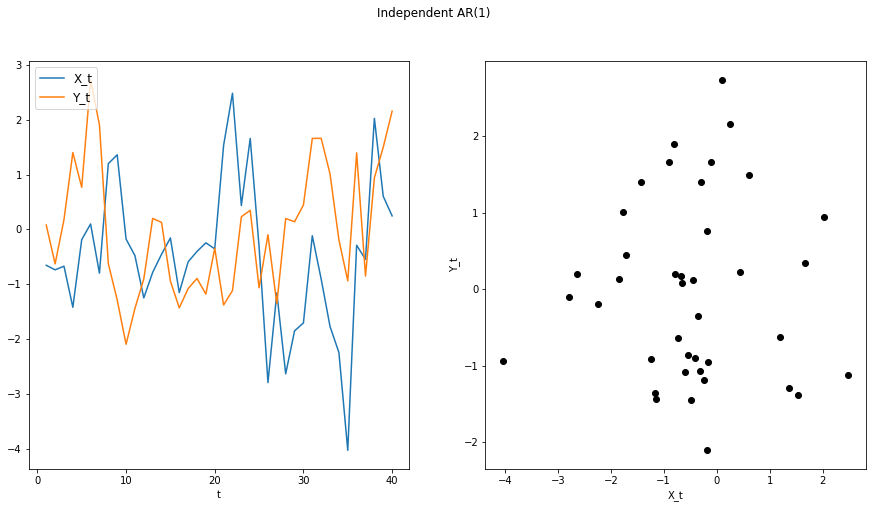

In [4]:
n = 40
max_lag = 0

indep = IndependentAR1()
X, Y = indep.simulate(n)
plot_1d_ts(X, Y, indep.name)
compute_dcorrx(X, Y, max_lag)
compute_mgcx(X, Y, max_lag)

In the crosscorrelated time series, the linear dependence will not be apparent at lag 0, but will be at lag 1.
$$\begin{bmatrix}
    X_t\\
    Y_t
    \end{bmatrix}
    =
    \begin{bmatrix}
    0 & 0.5\\
    0.5 & 0
    \end{bmatrix}
    \begin{bmatrix}
    X_{t-1}\\
    Y_{t-1}
    \end{bmatrix}
    +
    \begin{bmatrix}
    \epsilon_t\\
    \eta_t
    \end{bmatrix}$$

DCorrX test statistic: 0.025056970553235927
P Value: 0.181
Optimal Lag: 0
MGCX test statistic: 0.023857583948654323
P Value: 0.189
Optimal Lag: 0
Optimal Scale: [40, 40]


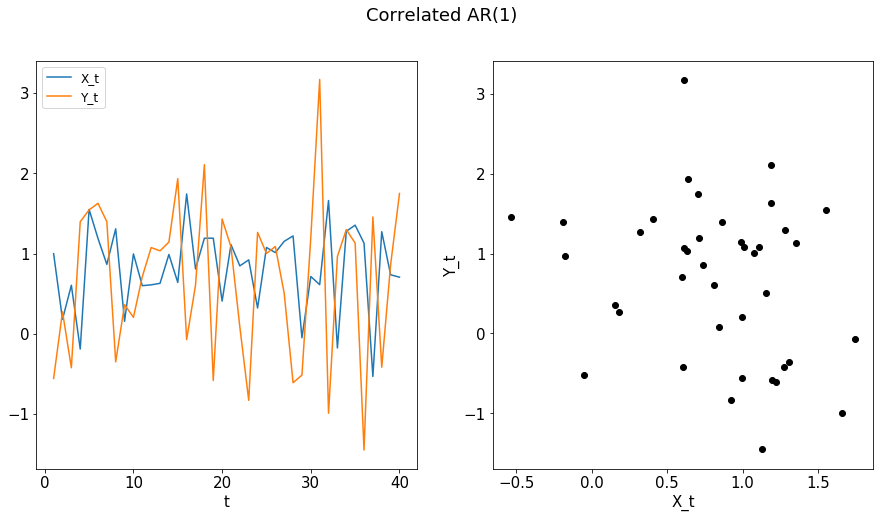

In [6]:
n = 40
max_lag = 0

corr = CorrelatedAR1()
X, Y = corr.simulate(n)
plot_1d_ts(X, Y, corr.name)
compute_dcorrx(X, Y, max_lag)
compute_mgcx(X, Y, max_lag)

DCorrX test statistic: 0.5968182277682754
P Value: 0.001
Optimal Lag: 1
MGCX test statistic: 0.5969321837660269
P Value: 0.001
Optimal Lag: 1
Optimal Scale: [39, 39]


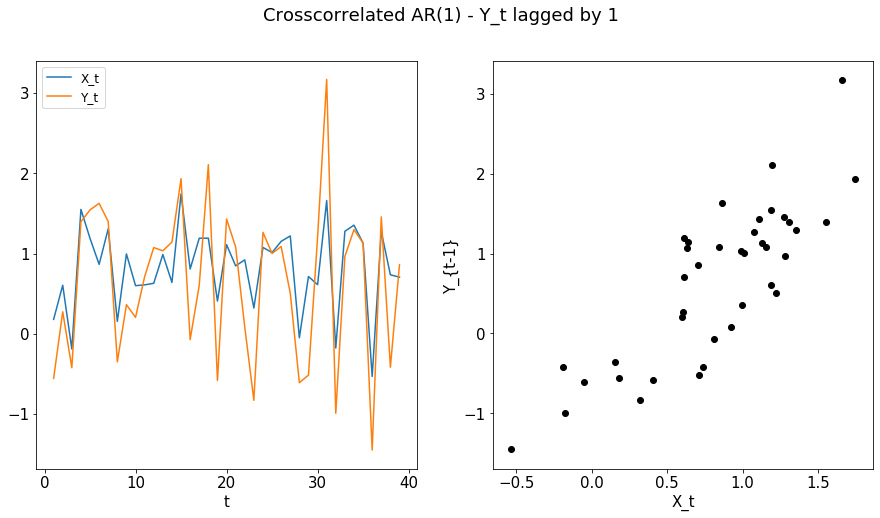

In [7]:
max_lag = 1

plot_1d_ts(X[1:n], Y[0:(n-1)], "Crosscorrelated AR(1) - Y_t lagged by 1", ylab = "Y_{t-1}")
compute_dcorrx(X, Y, max_lag)
compute_mgcx(X, Y, max_lag)

The final example is a nonlinearly related series, for which the Pearson's correlation may be insufficient.
$$\begin{bmatrix}
    X_t\\
    Y_t
    \end{bmatrix}
    =
    \begin{bmatrix}
    \epsilon_t Y_{t-1}\\
    \eta_t
    \end{bmatrix}$$

In [8]:
nonlin = NonlinearLag1()
X, Y = nonlin.simulate(n)

print("Pearson's Correlation at lag 0: " + str(pearsonr(X,Y)[0]))
print("Pearson's Correlation at lag 1: " + str(pearsonr(X[1:n],Y[0:(n-1)])[0]))

Pearson's Correlation at lag 0: -0.01595203754462765
Pearson's Correlation at lag 1: -0.35107979696502


DCorrX test statistic: 0.10071910648402307
P Value: 0.048
Optimal Lag: 1
MGCX test statistic: 0.2596750296407841
P Value: 0.012
Optimal Lag: 1
Optimal Scale: [5, 5]


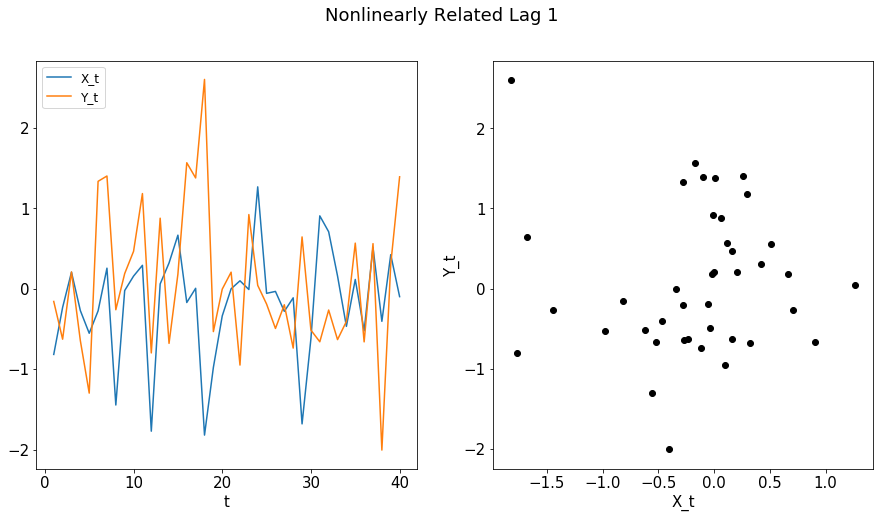

In [9]:
plot_1d_ts(X, Y, nonlin.name)
compute_dcorrx(X, Y, max_lag)
compute_mgcx(X, Y, max_lag)

### Understanding the Optimal Lag
The optimal lag allows the user to understand better the temporal nature of the relationship between $X_t$ and $Y_t$. The polt below shows the empirical distribution of the optimal lag estimate for $\text{MGC-X}$ as $n$ increases.

In [10]:
# Plot the distribution of optimal lag estimates.
def opt_lag_dist(optimal_lags_dcorrx, optimal_lags_mgcx, n, M = 10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7.5), sharey = True)
    plt.rcParams.update({'font.size': 15})
    
    ax1.set_xlabel('Lag j')
    ax1.set_title("DCorr-X, n = %d" % n)
    ax2.set_xlabel('Lag j')
    ax2.set_title("MGC-X, n = %d" % n)
    ax1.set_ylabel("Freq. of Optimal Lag Estimates")
    
    # Optimal lag predictions.
    weights = np.ones_like(optimal_lags_dcorrx)/float(len(optimal_lags_dcorrx))
    ax1.hist(optimal_lags_dcorrx, 
             bins = np.arange(M)-0.5, 
             weights = weights, 
             align = 'mid',
             edgecolor ='black',
             color = 'blue')
    weights = np.ones_like(optimal_lags_mgcx)/float(len(optimal_lags_mgcx))
    ax2.hist(optimal_lags_mgcx, 
             bins = np.arange(M)-0.5, 
             weights = weights, 
             align = 'mid',
             edgecolor ='black',
             color = 'red')
    
    plt.show()

We simulate a nonlinear process that has clear dependence at lag 3.
$$\begin{bmatrix}
    X_t\\
    Y_t
    \end{bmatrix}
    =
    \begin{bmatrix}
    \epsilon_t Y_{t-3}\\
    \eta_t
    \end{bmatrix}$$

In [11]:
def nonlinear_lag3(n, phi = 1, sigma2 = 1):
    # X_t and Y_t are together a bivarite nonlinear process.
    # Innovations follow N(0, sigma2).
    
    # Innovations.
    epsilons = np.random.normal(0.0, sigma2, n)
    etas = np.random.normal(0.0, sigma2, n)
    
    X = np.zeros(n)
    Y = np.zeros(n)
    for t in range(3):
        Y[t] = etas[t]
 
    for t in range(3,n):
        X[t] = phi*epsilons[t]*Y[t-3]
        Y[t] = etas[t]
        
    return X, Y

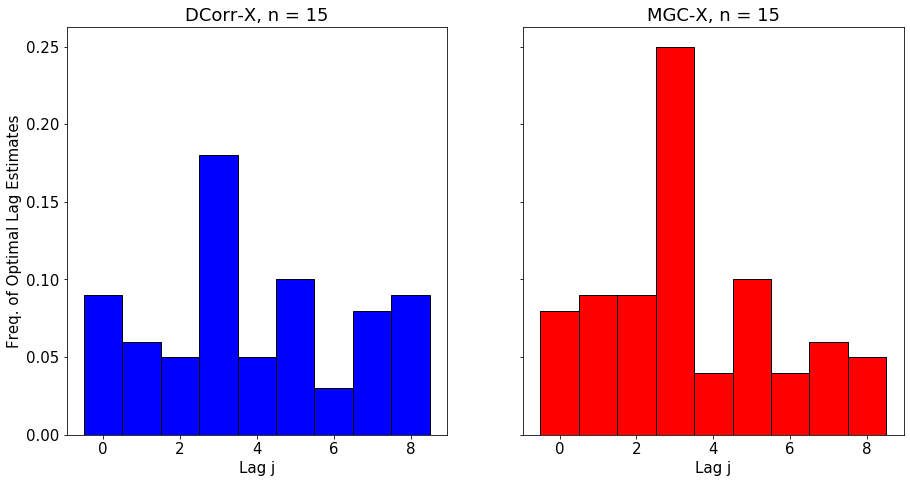

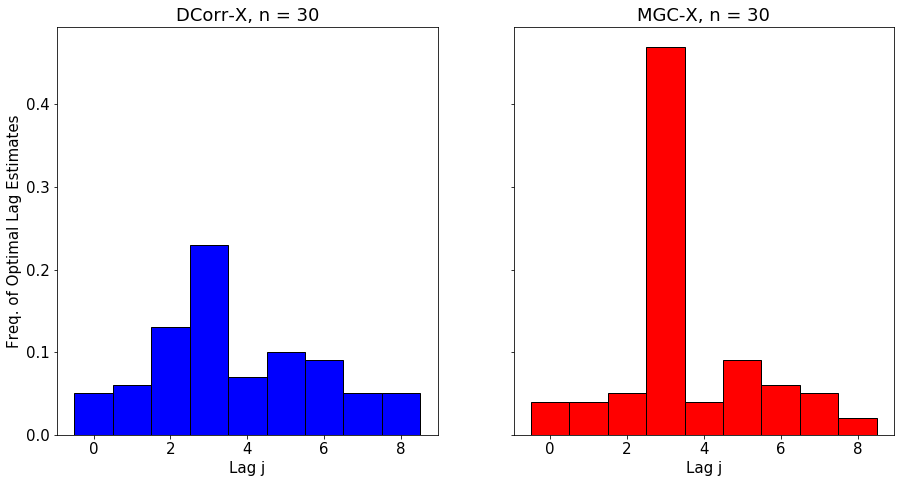

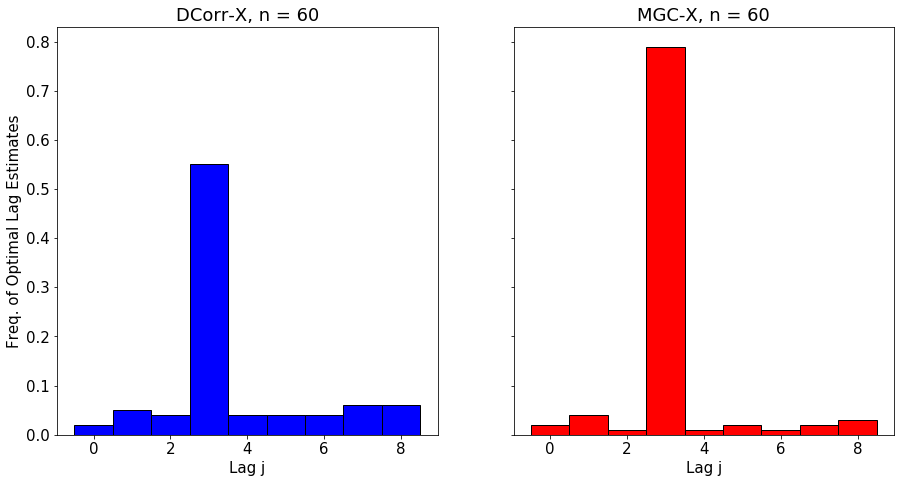

In [12]:
M = 10
num_sims = 100

dcorrx = DCorrX(max_lag = M)
mgcx = MGCX(max_lag = M)
optimal_lags_dcorrx = np.zeros(num_sims)
optimal_lags_mgcx = np.zeros(num_sims)

# Run experiments.
for n in [15, 30, 60]:
    for t in range(num_sims):
        X, Y = nonlinear_lag3(n)
        test_statistic, metadata = dcorrx.test_statistic(X, Y)
        optimal_lags_dcorrx[t] = metadata['optimal_lag']
        test_statistic, metadata = mgcx.test_statistic(X, Y)
        optimal_lags_mgcx[t] = metadata['optimal_lag']
    opt_lag_dist(optimal_lags_dcorrx, optimal_lags_mgcx, n)

`DCorrX` and `MGCX` both close in on the correct lag as `n` increases, with `MGCX` having higher accuracy due to advantages in nonlinear settings.

## Fast DCorrX and Fast MGCX

Similar to Fast `DCorr` and Fast `MGC`, a similar implementation exists for `DCorrX` and `MGCX`. In this implementation, nonoverlapping subsamples of size $b$ are taken from the series (after one block permutation of $Y_t$). Then, the test statistic $T_n$ is computed on each $b$-sized subsample. Finally, a Normal approximation is estimated from these observations, from which a P-Value is computed. To use the fast implementation (resulting in a slight and vanishing decrease in power), simply specify the `is_fast` argument in the `p_value` function.

In [13]:
M = 1
n = 1000
nonlin = NonlinearLag1()

X, Y = nonlin.simulate(n)

dcorrx = DCorrX(max_lag = M)
dcorrx_p_value, _ = dcorrx.p_value(X, Y, is_fast = True)
mgcx = MGCX(max_lag = M)
mgcx_p_value, _ = mgcx.p_value(X, Y, is_fast = True)

print("Fast DCorrX P Value:", dcorrx_p_value)
print("Fast MGCX P Value:", mgcx_p_value)

Fast DCorrX P Value: 2.986499936241671e-14
Fast MGCX P Value: 0.0
